In [1]:
import json
import requests as rq
import pandas as pd
import numpy as np
import time
import itertools
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
G=nx.Graph()
import pymongo
from pymongo import MongoClient
import community
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import cluster
import yellowbrick
from sklearn.cluster import MiniBatchKMeans, KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

egonets_data = pd.read_csv('egonets_data.csv')
egonets_data['num_communities'] = egonets_data['num_communities']/egonets_data['Summ_totalGames']
egonets_data['num_components'] = egonets_data['num_components']/egonets_data['Summ_totalGames']
variable_names = ['Modularity', 'Components', 'Density', 'Coverage', 'Giant_Component_Coverage', 
                  'AVG_degree','Perc_Important_Nodes', 'AVG_centrality']

egonets_data_numeric = egonets_data.iloc[:,3:11]
X = egonets_data_numeric.values

C:\ProgramData\Anaconda\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
X_std = StandardScaler().fit_transform(X)

In [20]:
# cojo 3 para pasar del 90%
sklearn_pca = PCA(n_components=3)
X_sklearn = sklearn_pca.fit_transform(X_std)

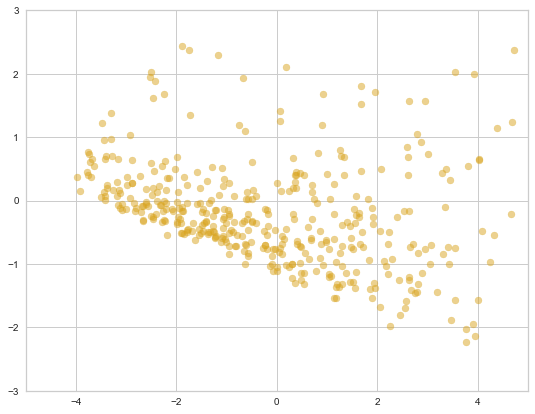

In [21]:
plt.figure(figsize = (9,7))
plt.scatter(X_sklearn[:,0],X_sklearn[:,1], c='goldenrod',alpha=0.5)
plt.ylim(-3,3)
plt.xlim(-5,5)
plt.show()

Estimated number of clusters: 7
Silhouette Coefficient: 0.488


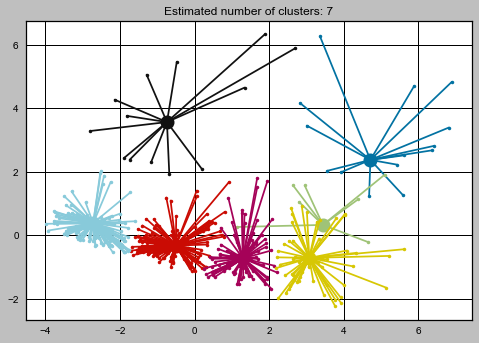

In [31]:
X = X_sklearn

from sklearn.cluster import AffinityPropagation
from sklearn import metrics
# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-65, damping = 0.8).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

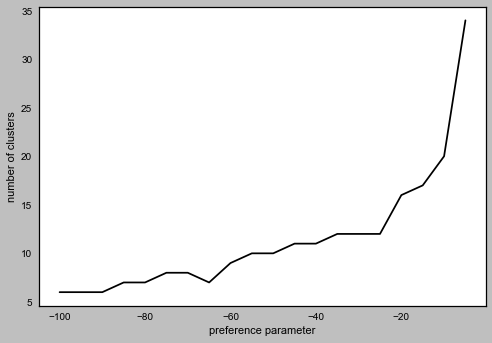

In [23]:
i = -100
x = []
y = []
while i < 0:
    af = AffinityPropagation(preference=i, damping = 0.8).fit(X)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    x.append(i)
    y.append(n_clusters_)
    i = i + 5
    
plt.style.use('grayscale')
plt.grid(False)
plt.xlabel('preference parameter')
plt.ylabel('number of clusters')
plt.plot(x,y)
#plt.savefig('preference_PCA.png', bbox_inches='tight')
plt.show()

In [7]:
egonets_data['Clusters_AF'] = pd.DataFrame(labels)

In [10]:
egonets_data.groupby("Clusters_AF").count()

,ego_id,num_nodes,num_communities,modularity,num_components,density,node_coverage,giant_component_coverage,avg_degree,perc_important_nodes,mean_centrality,Summ_ID,Summ_RANK,Role,Teamplay,Summ_totalGames,result
Clusters_AF,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48
3,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99
4,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95
5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
6,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105
7,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78
8,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [15]:
outliers = list(egonets_data[egonets_data['Clusters_AF'].isin([0,1,5,8])]["ego_id"])

In [16]:
egonets_clean = egonets_data[~egonets_data['ego_id'].isin(outliers)]

In [17]:
egonets_clean.groupby("Clusters_AF").count()

,ego_id,num_nodes,num_communities,modularity,num_components,density,node_coverage,giant_component_coverage,avg_degree,perc_important_nodes,mean_centrality,Summ_ID,Summ_RANK,Role,Teamplay,Summ_totalGames,result
Clusters_AF,,,,,,,,,,,,,,,,,
2,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48
3,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99
4,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95
6,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105
7,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78


In [18]:
egonets_data_numeric = egonets_clean.iloc[:,3:11]
X = egonets_data_numeric.values

In [32]:
outliers

[19459077,
 20501992,
 27281117,
 55718774,
 68901770,
 72199598,
 19178143,
 28855108,
 47297012,
 57729234,
 71099708,
 72641349,
 76378244,
 76479541]

In [33]:
egonets_data[egonets_data['ego_id'].isin(outliers)]

,ego_id,num_nodes,num_communities,modularity,num_components,density,node_coverage,giant_component_coverage,avg_degree,perc_important_nodes,mean_centrality,Summ_ID,Summ_RANK,Role,Teamplay,Summ_totalGames,result,Clusters_AF
0,19459077,18,0.028986,0.042192,0.014493,0.389706,0.061594,1.000000,6.235294,0.058824,0.046569,19459077,BRONZE,Bot - ADC,Equipo completo premade,69,0,0
1,20501992,22,0.428571,0.538265,0.285714,0.190476,0.750000,0.809524,3.809524,0.095238,0.036090,20501992,BRONZE,Bot - ADC,Premade de dos personas,7,1,8
3,27281117,45,0.351351,0.185415,0.081081,0.110994,0.297297,0.818182,4.772727,0.090909,0.015781,27281117,BRONZE,"No tengo preferencia alguna, relleno el hueco ...",Premade de tres o cuatro,37,2,5
29,55718774,91,0.080645,0.250694,0.016129,0.055431,0.362903,1.000000,4.933333,0.055556,0.014349,55718774,BRONZE,Jungle,Premade de tres o cuatro,62,2,5
43,68901770,77,1.000000,0.947368,1.000000,0.040000,1.000000,0.052632,3.000000,1.000000,0.000000,68901770,BRONZE,Mid,Premade de dos personas,19,1,1
50,72199598,185,1.000000,0.978261,1.000000,0.016393,1.000000,0.021739,3.000000,1.000000,0.000000,72199598,BRONZE,Support,Solo,46,3,1
106,19178143,67,0.132353,0.261931,0.073529,0.072727,0.242647,0.590909,4.727273,0.106061,0.006002,19178143,GOLD,Bot - ADC,Solo,68,3,5
323,28855108,49,1.000000,0.916667,1.000000,0.063830,1.000000,0.083333,3.000000,1.000000,0.000000,28855108,SILVER,Mid,Premade de dos personas,12,1,1
371,47297012,53,0.136364,0.308949,0.022727,0.093514,0.295455,1.000000,4.769231,0.057692,0.024449,47297012,SILVER,"No tengo preferencia alguna, relleno el hueco ...",Premade de tres o cuatro,44,2,5
386,57729234,70,0.235294,0.331171,0.039216,0.075874,0.338235,0.927536,5.159420,0.101449,0.016859,57729234,SILVER,"No tengo preferencia alguna, relleno el hueco ...",Premade de tres o cuatro,51,2,5


# Removing Edge Density

In [35]:
egonets_clean.iloc[:,[3,4,6,7,8,9,10]].describe()

,modularity,num_components,node_coverage,giant_component_coverage,avg_degree,perc_important_nodes,mean_centrality
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,4.250000e+02
mean,0.792952,0.420278,0.737265,0.425387,3.665251,0.014715,6.586410e-04
std,0.161654,0.244986,0.142911,0.257291,0.399641,0.010855,1.115726e-03
min,0.275340,0.005525,0.277668,0.005185,3.011852,0.001738,3.258775e-08
25%,0.692799,0.226981,0.640884,0.206837,3.349919,0.007818,5.248589e-05
50%,0.828038,0.397129,0.757292,0.409873,3.617369,0.011610,2.163925e-04
75%,0.922608,0.604805,0.846133,0.617813,3.902326,0.018072,7.804082e-04
max,0.998764,0.985251,0.995575,1.000000,5.124874,0.083082,8.589959e-03
